In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=90.0,max_zoom=1.1,max_lighting=0.2,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [5]:
np.random.seed(42)


In [6]:
# from pathlib import Path
# path = Path("train/")

# print(path)
# for c in data.classes:
#     print(c)
#     verify_images(path/c, delete=True)

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [8]:
loss_func = FocalLoss(gamma=2.)

In [9]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [10]:
src

LabelLists;

Train: LabelList (65932 items)
x: ImageList
Image (3, 231, 201),Image (3, 180, 204),Image (3, 407, 259),Image (3, 290, 280),Image (3, 243, 248)
y: CategoryList
class-1059,class-1059,class-1059,class-1059,class-1059
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 205, 183),Image (3, 230, 144),Image (3, 1052, 936),Image (3, 176, 230),Image (3, 217, 314)
y: CategoryList
class-448,class-966,class-204,class-540,class-854
Path: train-snakes-cropped;

Test: None

In [11]:
data = src.transform(tfms,size=256).databunch(bs=24).normalize()

In [12]:
data.c

45

In [13]:
data

ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-1059,class-1059,class-1059,class-1059,class-1059
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-448,class-966,class-204,class-540,class-854
Path: train-snakes-cropped;

Test: None

In [14]:
data.valid_ds.items

array([WindowsPath('train-snakes-cropped/class-448/3806cc0507bf3514febd4ba3fba90f7a.jpg'),
       WindowsPath('train-snakes-cropped/class-966/843a8333ecd453eb3c96a4f6eefeb17f.jpg'),
       WindowsPath('train-snakes-cropped/class-204/8acd5dd7070e7de72b0d819c4b0a1e5e.jpg'),
       WindowsPath('train-snakes-cropped/class-540/f49a37f0075baf0fcfb35cb85ccba2c0.jpg'), ...,
       WindowsPath('train-snakes-cropped/class-536/f6359e229b54f6d288230fcbaa02ea04.jpg'),
       WindowsPath('train-snakes-cropped/class-204/001d86350f401dafb18d71d5c1bb78b9.jpg'),
       WindowsPath('train-snakes-cropped/class-784/95462eb72cdbfefacb50614322335268.jpg'),
       WindowsPath('train-snakes-cropped/class-536/acbd9e8561e3efcb96b47bcc1b88a1c7.jpg')], dtype=object)

In [15]:
alpha=0.99
mom=0.9
eps=1e-6
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

In [16]:
learn = cnn_learner(data, models.densenet121,pretrained=False, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func,opt_func=opt_func,wd=1e-2)

In [17]:
learn.unfreeze()

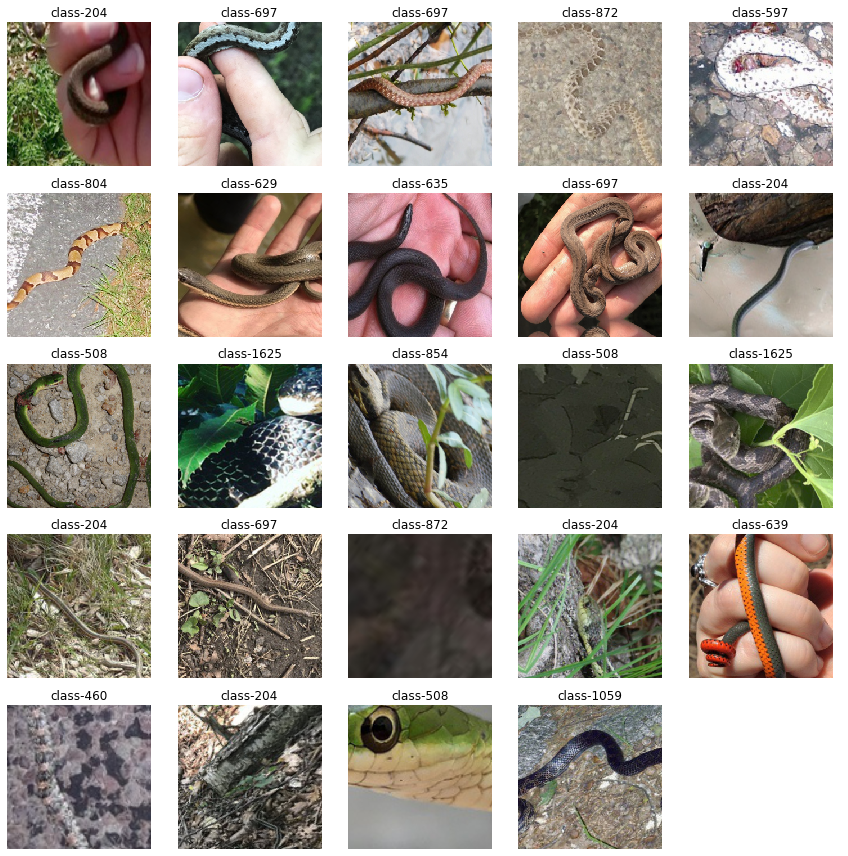

In [18]:
data.show_batch(6,figsize=(12,12))

In [19]:
learn= learn.mixup(alpha=0.2)

In [20]:
learn.bn_wd=False

In [21]:
learn.true_wd=True

In [27]:
learn = learn.to_fp16(dynamic=True)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


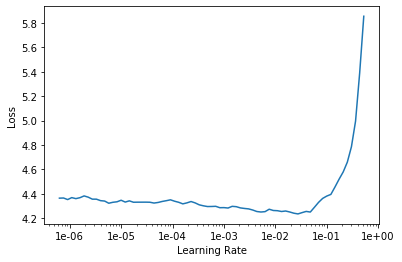

In [23]:
learn.recorder.plot()

In [24]:
lr=7.5e-3

In [25]:
learn.fit_one_cycle(40, lr, div_factor=10, pct_start=0.3)


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,3.114807,3.138670,0.837712,0.162288,0.029878,27:27
1,2.935905,2.753461,0.785415,0.214585,0.061007,21:13
2,2.883889,3.532651,0.751623,0.248377,0.094670,28:36
3,2.730357,2.453233,0.718862,0.281138,0.118752,29:12


KeyboardInterrupt: 

In [26]:
learn.save('dn121-with-focal-loss-cropped')

In [29]:
learn.fit_one_cycle(40, lr, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,2.464605,2.145291,0.647940,0.352060,0.172802,27:44
1,2.417928,2.093790,0.628526,0.371474,0.210071,27:30
2,2.349547,1.917037,0.620275,0.379725,0.226276,27:36
3,2.349279,2.015198,0.615361,0.384639,0.235884,27:32
4,2.337365,1.946208,0.606140,0.393860,0.267703,27:32


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
learn.save('dn121-with-focal-loss-cropped-round-2')